# Necessary Imports

In [10]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , SeparableConv2D, MaxPooling2D , Flatten , Dropout , BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,array_to_img
from keras.callbacks import ReduceLROnPlateau 
from keras import backend as K
from keras import optimizers
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Dataset Loading

In [2]:
train_data_dir = '/content/drive/MyDrive/Diabetic Rentinopathy/Final_Dataset/'

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip = True,
        validation_split=0.2
        )

train_gen = train_datagen.flow_from_directory(
        directory = train_data_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        subset='training'
        )
val_gen = train_datagen.flow_from_directory(
        directory = train_data_dir,
        target_size=(224, 224),
        batch_size=16,
        class_mode='categorical',
        subset='validation'
        )

Found 2931 images belonging to 5 classes.
Found 730 images belonging to 5 classes.


In [5]:
image_size = (224,224,3)

# Model Creation

In [6]:
base_model = tf.keras.applications.ResNet152V2(input_shape=image_size,
                                               include_top=False,
                                               weights="imagenet")

234545216/234545216 [==============================] - 1s 0us/step


In [7]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [8]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                        

## Plotting the Model

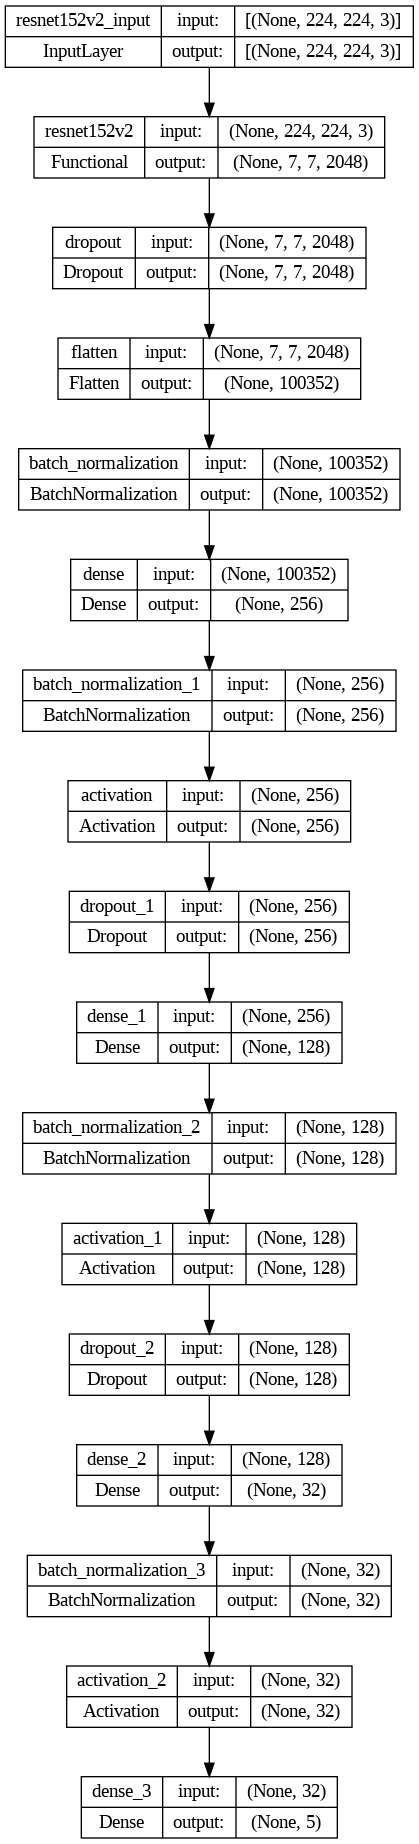

In [12]:
plot_model(model, to_file='ResNet.png', show_shapes=True,show_layer_names=True)
Image(filename='ResNet.png')

In [14]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

## Declaring Callbacks

In [18]:
EPOCHS = 30
earlystop = keras.callbacks.EarlyStopping(verbose = 1, patience=5)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                            patience = 2,
                                                            verbose = 1,
                                                            factor = 0.8, 
                                                            min_lr = 1e-6)

checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Diabetic Rentinopathy/Models/ResNet52.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
mycallbacks = [earlystop, learning_rate_reduction,checkpoint]

In [19]:
history = model.fit(train_gen,
                    batch_size = 16, 
                    validation_data=val_gen,
                    epochs=EPOCHS, 
                    callbacks=mycallbacks
                    )

Epoch 1/30
184/184 [==============================] - ETA: 0s - loss: 1.0741 - accuracy: 0.8642 - precision: 0.8160 - recall: 0.4145 - auc: 0.8524 - f1_score: 0.5392
Epoch 1: val_loss improved from inf to 0.99353, saving model to /content/drive/MyDrive/Diabetic Rentinopathy/Models/ResNet52.h5
184/184 [==============================] - 1365s 7s/step - loss: 1.0741 - accuracy: 0.8642 - precision: 0.8160 - recall: 0.4145 - auc: 0.8524 - f1_score: 0.5392 - val_loss: 0.9935 - val_accuracy: 0.8877 - val_precision: 0.7888 - val_recall: 0.5986 - val_auc: 0.8945 - val_f1_score: 0.6761 - lr: 0.0010
Epoch 2/30
184/184 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.8865 - precision: 0.8167 - recall: 0.5578 - auc: 0.9052 - f1_score: 0.6578
Epoch 2: val_loss improved from 0.99353 to 0.74089, saving model to /content/drive/MyDrive/Diabetic Rentinopathy/Models/ResNet52.h5
184/184 [==============================] - 327s 2s/step - loss: 0.8648 - accuracy: 0.8865 - precision: 0.8

## Visualizing Curves

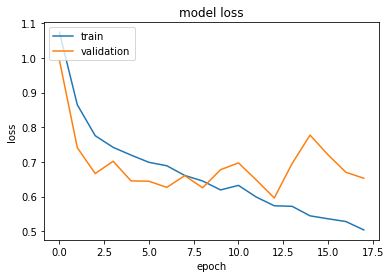

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

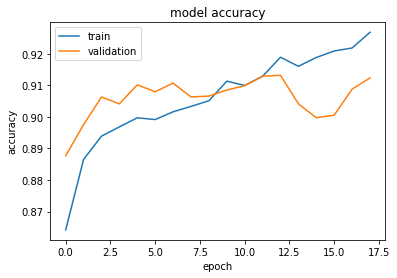

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Prediction

In [37]:
complete_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip = True,
        )

complete_generator = complete_datagen.flow_from_directory(
        directory = train_data_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode=None,
        )

Found 3661 images belonging to 5 classes.


In [40]:
STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict(complete_generator, steps=STEP_SIZE_COMPLETE)
train_preds = [np.argmax(pred) for pred in train_preds]

3661/3661 [==============================] - 324s 88ms/step


In [46]:
print(set(train_preds))

{0, 1, 2, 3, 4}


In [69]:
np.unique(complete_generator.classes, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([1805,  370,  999,  193,  294]))

In [65]:
for i in range(5):
    value = train_preds.count(i)
    print(f'Class {i} -> {value}')

Class 0 -> 1790
Class 1 -> 218
Class 2 -> 1175
Class 3 -> 401
Class 4 -> 77
